 This file will import Our World In Health Data from https://github.com/owid/covid-19-data/tree/master/public/data and clean it to remove NA values and include the relevant predictors needed. 


Documentation for what the variables mean: https://github.com/owid/covid-19-data/tree/master/public/data

**stringency_index**:
Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response).

**positive_rate**: The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case).

**new_vaccinations_smoothed**: New COVID-19 vaccination doses administered (7-day smoothed).

**weekly_hosp_admissions**: Number of COVID-19 patients newly admitted to hospitals in a given week.

In [332]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.utils import shuffle

In [333]:
df = pd.read_csv('owid-covid-data.csv') # Entire Dataset
df.location.value_counts()[:20] # High income 825

Mexico                 846
Argentina              846
Thailand               843
Taiwan                 831
South Korea            825
Macao                  825
World                  825
Upper middle income    825
North America          825
United States          825
Asia                   825
Lower middle income    825
Japan                  825
China                  825
High income            825
Singapore              824
Canada                 824
Europe                 824
European Union         824
Vietnam                824
Name: location, dtype: int64

Need to isolate for the United States 

In [334]:
us_df = df[df.location == 'United States']
world_df = df[df.location == 'World']
us_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
171164,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
171165,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
171166,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
171167,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
171168,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8926.0,-3.59,-2.63,-26.811643


In [335]:
# Getting rid of the irrelevant variables such as general health predictors or contient name. 
us_df.drop(us_df.columns[48:],axis=1, inplace=True)
us_df.drop(us_df.columns[0:2],axis=1, inplace=True)
world_df.drop(world_df.columns[48:],axis=1, inplace=True)
world_df.drop(world_df.columns[0:2],axis=1, inplace=True)

<AxesSubplot:>

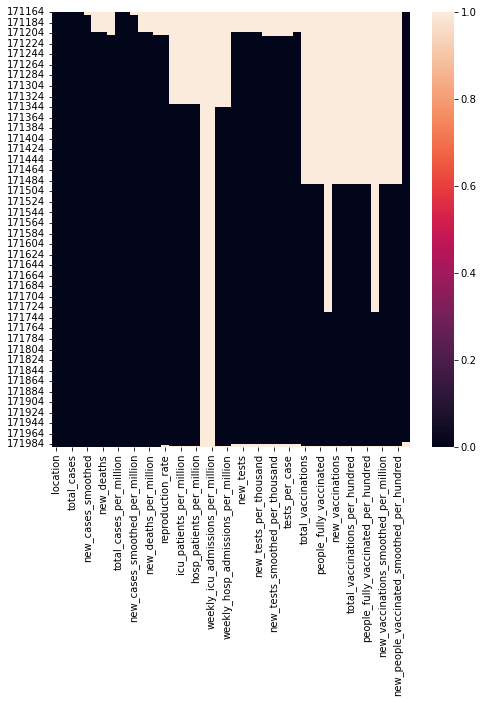

In [336]:
plt.figure(figsize=(8,8))
sns.heatmap(us_df.isna())

<AxesSubplot:>

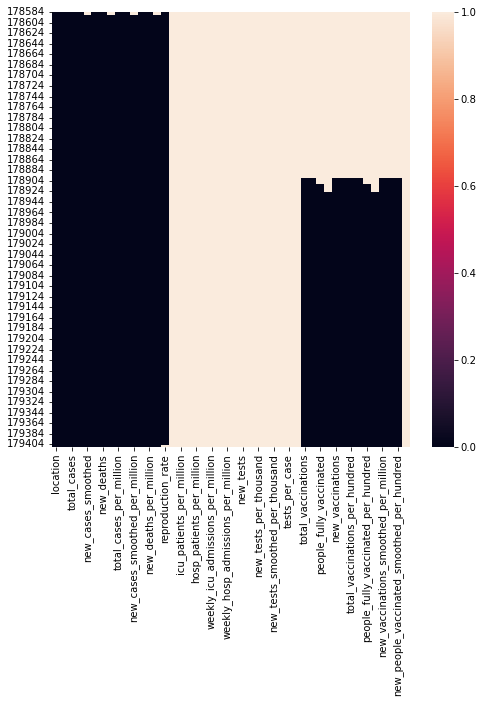

In [337]:
plt.figure(figsize=(8,8))
sns.heatmap(world_df.isna())

In [338]:
us_df.dropna(axis=1, thresh=300, inplace=True) # Drops columns that don't have a minimum of 300 non-na values. 
world_df.dropna(axis=1, thresh=300, inplace=True) # Drops columns that don't have a minimum of 300 non-na values. 

us_df.date = pd.to_datetime(us_df.date)
world_df.date = pd.to_datetime(world_df.date)

us_df = us_df[us_df.date > '2020-03-01']
world_df = world_df[world_df.date > '2020-03-01']

us_df.reset_index(drop=True,inplace=True)
world_df.reset_index(drop=True,inplace=True)

us_df.to_csv('us_cleaned_health_data.csv')
world_df.to_csv('world_cleaned_health_data.csv')

## Checking correlations

In [342]:
df = pd.read_csv('tdm_res.csv')
df.date = pd.to_datetime(df.date)
us_df.date = pd.to_datetime(us_df.date)
us_df = us_df[(us_df.date >= df.date.min()) & (us_df.date <= df.date.max())]
us_df = us_df[['new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 'new_vaccinations_smoothed', 
                'positive_rate', 'new_cases', 'date']]
df = df.merge(us_df, on='date')

In [343]:
pre_delta = df[df.date < '2021-06-01']
predictor_list = pre_delta.columns[4:]
print(predictor_list)

Index(['new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions',
       'new_vaccinations_smoothed', 'positive_rate', 'new_cases'],
      dtype='object')


In [344]:
def calc_corr(dataframe, predictor, spearman=False, kend=False):
    null_lst = []
    num_sims = 20000
    if kend:
        first_corr, _ = stats.kendalltau(dataframe['prediction'], dataframe[predictor])
        for sim in range(num_sims):
            null_predictor = shuffle(dataframe[predictor].values)
            corr, _ = stats.kendalltau(dataframe['prediction'], null_predictor)
            null_lst.append(corr)
        p_val = np.sum(np.abs(np.array(null_lst)) >= np.abs(first_corr)) / num_sims
        return np.around(first_corr,3), np.around(p_val,3)
    
    elif spearman:
        first_corr, _ = stats.spearmanr(dataframe['prediction'], dataframe[predictor])
        for sim in range(num_sims):
            null_predictor = shuffle(dataframe[predictor].values)
            corr, _ = stats.spearmanr(dataframe['prediction'], null_predictor)
            null_lst.append(corr)
        p_val = np.sum(np.abs(np.array(null_lst)) >= np.abs(first_corr)) / num_sims
        return np.around(first_corr,3), np.around(p_val,3)
    
    else:
        first_corr, _ = stats.pearsonr(dataframe['prediction'], dataframe[predictor])
        for sim in range(num_sims):
            null_predictor = shuffle(dataframe[predictor].values)
            corr, _ = stats.pearsonr(dataframe['prediction'], null_predictor)
            null_lst.append(corr)
        p_val = np.sum(np.abs(np.array(null_lst)) >= np.abs(first_corr)) / num_sims
        return np.around(first_corr,3), np.around(p_val,3)

In [345]:
pearson_corr = []
pearson_p_val = []
for predictor in predictor_list:
    corr, p_val = calc_corr(pre_delta, predictor=predictor)
    pearson_corr.append(corr)
    pearson_p_val.append(p_val)

In [346]:
spearman_corr = []
spearman_p_val = []
for predictor in predictor_list:
    corr, p_val = calc_corr(pre_delta, predictor, spearman=True)
    spearman_corr.append(corr)
    spearman_p_val.append(p_val)

In [347]:
kendal_corr = []
kendal_p_val = []
for predictor in predictor_list:
    corr, p_val = calc_corr(pre_delta, predictor, kend=True)
    kendal_corr.append(corr)
    kendal_p_val.append(p_val)

In [348]:
analysis_df = pd.DataFrame({'Pearson Correlation' : pearson_corr,'Spearman Correlation' : spearman_corr, 'Kendall Correlation' : kendal_corr})
p_val_df = pd.DataFrame({'Pearson p-value': pearson_p_val, 'Spearman p-value': spearman_p_val, 'Kendall p-value': kendal_p_val})
analysis_df.index = predictor_list
analysis_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases_smoothed,-0.585,-0.537,-0.374
new_deaths_smoothed,-0.418,-0.400,-0.268
weekly_hosp_admissions,-0.579,-0.536,-0.370
new_vaccinations_smoothed,0.307,0.287,0.202
positive_rate,-0.626,-0.583,-0.417
new_cases,-0.551,-0.511,-0.355


In [349]:
with open('latex_test.tex', 'w') as tf:
    tf.write(analysis_df.to_latex(index=True))

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_58206/2023377391.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(analysis_df.to_latex(index=True))


[<AxesSubplot:> <AxesSubplot:>]


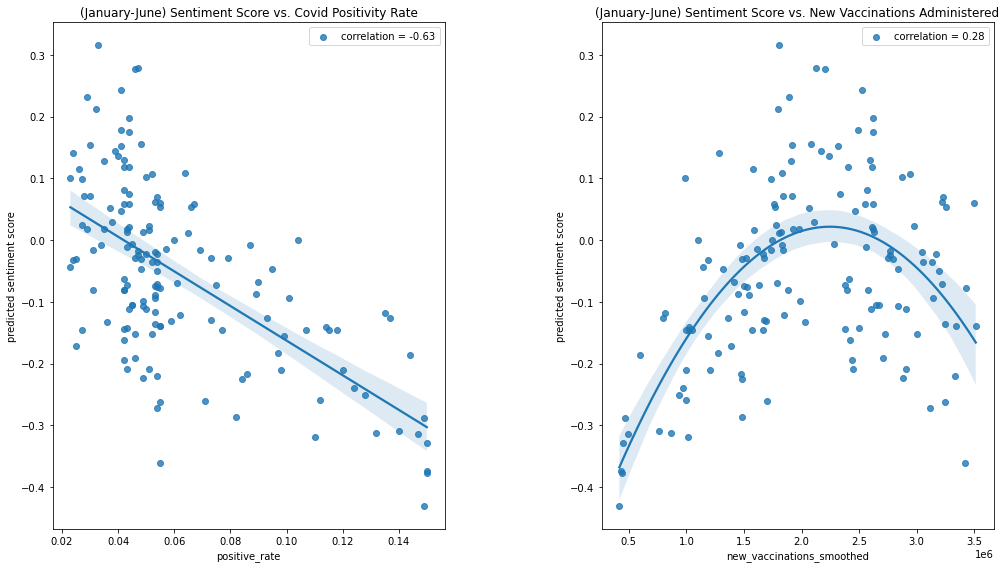

In [191]:
fig, axs = plt.subplots(ncols=2, figsize=(14,8))
sns.regplot(x=pre_delta.positive_rate, y=pre_delta.prediction, ax=axs[0], label='correlation = -0.63');
axs[0].set_title('(January-June) Sentiment Score vs. Covid Positivity Rate');
axs[0].set_ylabel('predicted sentiment score');
axs[0].legend()

sns.regplot(x=pre_delta.new_vaccinations_smoothed, y=pre_delta.prediction, ax=axs[1], order=2, label='correlation = 0.28');
axs[1].set_title('(January-June) Sentiment Score vs. New Vaccinations Administered');
axs[1].set_ylabel('predicted sentiment score');
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=None)
axs[1].legend()

plt.savefig('figures/pre_delta_correlation_vaccines.png')

## checking the annotations

In [175]:
ta = pd.read_csv('annotations/shana_annot.csv')
ta.dropna(axis=0, subset='Sentence', inplace=True)
ta.reset_index(drop=True,inplace=True)

In [176]:
mine = pd.read_csv('annotations/covid_annotations.csv')

In [177]:
# mine.drop(13,axis=0,inplace=True)
# mine = mine.iloc[:len(ta)]
mine.reset_index(drop=True,inplace=True)

In [178]:
mine['g_label'] = mine.Label

In [179]:
df = pd.concat((ta,mine.g_label),axis=1,)

In [181]:
df[~(df.Label == df.g_label)][:30]

,Sentence,Label,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,g_label
13,We are in a new wave of rising positivity in C...,0.0,NaN,NaN,NaN,NaN,1
16,It is critical that we actually understand whe...,1.0,NaN,NaN,NaN,NaN,0
17,Minnesota outbreak tied to Trump rally.,0.0,NaN,NaN,NaN,NaN,1
18,In an open letter published Friday by Pfizer C...,1.0,NaN,NaN,NaN,NaN,0
23,"But now, the country is averaging more than 55...",0.0,NaN,NaN,NaN,NaN,1
28,We know how quickly it spreads. We know the pr...,1.0,NaN,NaN,NaN,NaN,0
30,There's not a place in the country where the v...,0.0,NaN,NaN,NaN,NaN,1
31,"Some universities will do better than others, ...",1.0,NaN,NaN,NaN,NaN,0
32,UT epidemiologists project between 82 and 183 ...,0.0,NaN,NaN,NaN,NaN,1
33,UT epidemiologists project between 1000 and 10...,1.0,NaN,NaN,NaN,NaN,0


In [109]:
ta.to_csv('(TA)annotations.csv')

In [110]:
ta

,Sentence,Label,Reason for Highlight
0,"Countys milestone comes after it hit 4,000 dea...",0.0,Ambiguous - milestone could be good or bad. Al...
1,Riverside Countys coronavirus death toll surpa...,0.0,NaN
2,Numbers posted on the countys coronavirus webs...,0.0,NaN
3,Our county team continues to work diligently t...,1.0,NaN
4,"Orange County , which has about 700,000 more p...",1.0,NaN
...,...,...,...
430,Vaccination rates are increasing across the co...,1.0,NaN
431,Covid cases are at their highest point right now.,0.0,NaN
432,Covid cases increasing isn’t a problem by itse...,1.0,NaN
433,There are many more treatments available now t...,1.0,NaN
